<a href="https://colab.research.google.com/github/chahalinder0007/Mytest/blob/master/pytorch_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lera

In [0]:
import torch
import torchvision.datasets as data
import numpy as np
import lera

In [3]:

lera.log_hyperparams({
  'title': 'GAN ',
  'batch_size': 1,
  'epochs': 15000,
  'optimizer': 'SGD',
  'lr': 0.00001,
  
  })

lera: open https://lera.ai/m/e1fe69 to view the progress


{'batch_size': 1,
 'epochs': 15000,
 'lr': 1e-05,
 'optimizer': 'SGD',
 'title': 'GAN '}

In [4]:
#downloading trainining data and storing it in ./mnist
down_train_data=data.MNIST(root="./mnist/",download=True)
#entire thing just gets the index as in the required class.


idx=down_train_data.targets==3
down_train_data.targets=down_train_data.targets[idx]
down_train_data.data=down_train_data.data[idx]


X_train=down_train_data.train_data.reshape(-1,784).to(torch.float32).cuda()
Y_train=down_train_data.train_labels.reshape(-1,1).to(torch.float32)
#retreiving the test dataset
down_test_data=data.MNIST(root="./mnist/",download=True,train=False)
X_test=down_test_data.test_data.reshape(-1,784)
Y_test=down_test_data.test_labels.reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
class net(torch.nn.Module):
    def __init__(self,D_in,D_out):
        super(net,self).__init__()
        self.gen1=torch.nn.Linear(32,256) #only thing you need to change for the dimension of noise
        self.linear2=torch.nn.Linear(256,256)
        self.gen_out=torch.nn.Linear(256,D_in)
        
    def forward(self,x):
        indata=self.gen1(x)
        indata=torch.relu(indata)

        indata2=self.linear2(indata)
        indata2=torch.relu(indata2)

        out=self.gen_out(indata)
        out=torch.tanh(out)

        return out

gen=net(784,1)
#for training


optimizer_gen=torch.optim.Adam(gen.parameters(),lr=0.0001)
class bet(torch.nn.Module):
    def __init__(self,D_in,D_out):
        super(bet,self).__init__()

        self.disc1=torch.nn.Linear(D_in,256)
        self.disc2=torch.nn.Linear(256,256)
        self.disc_out= torch.nn.Linear(256,D_out)
    def forward(self,x):
        indata=self.disc1(x)
        indata=torch.relu(indata)
        #indata=torch.tanh(indata)

        indata2=self.disc2(indata)
        indata2=torch.relu(indata2)

        out=self.disc_out(indata)
        out=torch.sigmoid(out)

        return out

disc=bet(784,1)
#for training
criterion = torch.nn.BCELoss()
optimizer_disc=torch.optim.Adam(disc.parameters(),lr=0.0001)

In [0]:
gen=gen.cuda()
disc=disc.cuda()

In [0]:
def loss_disc(dis_real_image,dis_fake_image):
  #to_r=-torch.mean(torch.log(dis_real_image)+torch.log(1.0-dis_fake_image))
  #print(dis_fake_image,":::::",dis_real_image)
  to_r=torch.mean(((1.0-dis_real_image))**2 + ((dis_fake_image))**2)
  return to_r

def loss_gen_l(dis_fake_image):
  to_r=torch.mean((dis_fake_image))**2
  #to_r=-torch.mean(torch.log(dis_fake_image))
  return to_r

In [8]:
X_train.size()

torch.Size([6131, 784])

In [9]:
X_train=X_train.resize(1,X_train.size()[0],784)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [17]:
for i in range(500):
    for j in range(X_train.size()[0]):
        
        feeder=torch.randn((X_train.size()[1],32)).cuda()
         
        fake_image=gen(feeder)
        dis_real_image=disc(X_train[j])
        #print(dis_real_image)
        dis_fake_image=disc(fake_image)
                                                       #noise                                     #noise                             #noise
        total_loss_disc=criterion(dis_real_image,((0-0.03)*torch.rand(X_train.size()[1],1)+0.03).cuda())+criterion(dis_fake_image,((0.974-1.0)*torch.rand(X_train.size()[1],1)+1).cuda())#loss_disc(dis_real_image=dis_real_image,dis_fake_image=dis_fake_image)

        lera.log("Disc_loss",total_loss_disc.item())
        #if j%9000 == 0:
        #    print(j)
        #    print("Discriminator loss: ",total_loss_disc.item())
            
        optimizer_disc.zero_grad()
        total_loss_disc.backward()
        
        optimizer_disc.step()

        feeder=torch.randn((X_train.size()[1],32)).cuda()
        fake_image=gen(feeder)
        dis_fake_image=disc(fake_image)


        loss_gen=criterion(dis_fake_image,torch.zeros(X_train.size()[1]).cuda())#loss_gen_l(dis_fake_image)
        lera.log("Gen_loss",loss_gen.item())
        #if j%9000==0:
        #    print("Generator loss (although its not really):",loss_gen.item())
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
    

    
    print("itter::",i)

       

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([6131])) that is different to the input size (torch.Size([6131, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


itter:: 0
itter:: 1
itter:: 2
itter:: 3
itter:: 4
itter:: 5
itter:: 6
itter:: 7
itter:: 8
itter:: 9
itter:: 10
itter:: 11
itter:: 12
itter:: 13
itter:: 14
itter:: 15
itter:: 16
itter:: 17
itter:: 18
itter:: 19
itter:: 20
itter:: 21
itter:: 22
itter:: 23
itter:: 24
itter:: 25
itter:: 26
itter:: 27
itter:: 28
itter:: 29
itter:: 30
itter:: 31
itter:: 32
itter:: 33
itter:: 34
itter:: 35
itter:: 36
itter:: 37
itter:: 38
itter:: 39
itter:: 40
itter:: 41
itter:: 42
itter:: 43
itter:: 44
itter:: 45
itter:: 46
itter:: 47
itter:: 48
itter:: 49
itter:: 50
itter:: 51
itter:: 52
itter:: 53
itter:: 54
itter:: 55
itter:: 56
itter:: 57
itter:: 58
itter:: 59
itter:: 60
itter:: 61
itter:: 62
itter:: 63
itter:: 64
itter:: 65
itter:: 66
itter:: 67
itter:: 68
itter:: 69
itter:: 70
itter:: 71
itter:: 72
itter:: 73
itter:: 74
itter:: 75
itter:: 76
itter:: 77
itter:: 78
itter:: 79
itter:: 80
itter:: 81
itter:: 82
itter:: 83
itter:: 84
itter:: 85
itter:: 86
itter:: 87
itter:: 88
itter:: 89
itter:: 90
itter:: 9

In [0]:
import matplotlib.pyplot as plt
import cv2

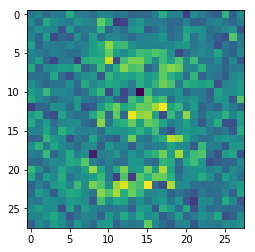

In [25]:
feeder=torch.randn((8,32)).cuda()
kk=gen(feeder).detach().cpu()
plt.imshow(kk[3].reshape(28,28))